In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import sys
sys.path.append("..")

In [95]:
%matplotlib inline
# %config InlineBackend.figure_format = "retina"
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from collections import OrderedDict
from src.config import cfg

In [96]:
processed_path = cfg.processed_path
batch_size = cfg.batch_size
epochs = cfg.epochs
base_learning_rate = cfg.base_learning_rate
gamma = cfg.gamma
power = cfg.power
weight_decay = cfg.weight_decay
num_of_tries = cfg.num_of_tries

train_losses, valid_losses, test_losses = [], [], []

In [97]:
# Set up place to download pretrained model from internet
import os
os.environ['TORCH_HOME'] = '../models/pretrained/'

In [98]:
from src.data.dataload import DataLoader
from src.data.datasplit import DataSplit
from src.data.dataload import FaceToBMIDataset

In [99]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Set this when run on laptop otherwise comment it out
train_on_gpu = False

CUDA is not available.  Training on CPU ...


In [100]:
print("Loading data ....")
total_dataset = torch.load(processed_path+"total_dataset.pt")
print("Done!")

Loading data ....
Done!


In [101]:
model = models.resnet50(pretrained=True)
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [102]:
for param in model.parameters():
  param.requires_grad = False

from collections import OrderedDict

fc = nn.Sequential(OrderedDict([
    ("output", nn.Linear(2048, 1))
]))

model.fc = fc
print(model.fc)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
    print("Model's moved in GPU!")

Sequential(
  (output): Linear(in_features=2048, out_features=1, bias=True)
)


In [43]:
# Checking if trained model is empty, if it is not then reload it
import os
if len(os.listdir("../models/training/")) == 0:
    print("No current training model!")
else:
    # model.load_state_dict(torch.load('../models/training/on_training_model.pt')) #Using this when training with GPU
    model.load_state_dict(torch.load('../models/training/on_training_model.pt', map_location=torch.device('cpu')));

In [106]:
def train_val_test_split():
    print("Generating data!")
    split = DataSplit(total_dataset, shuffle=True)
    train_loader, val_loader, test_loader = split.get_split(batch_size=batch_size)
    return train_loader, val_loader, test_loader

def get_criterion():
    #Setting criterion and loggin
    criterion = nn.SmoothL1Loss()
    if train_on_gpu:
        criterion.cuda()

def get_optimizer(epoch):
    learning_rate = base_learning_rate*(1+gamma*epoch)**(-power)
    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    return optimizer

def get_test_criterion():
    test_criterion = nn.L1Loss()
    if train_on_gpu: test_criterion = test_criterion.cuda()
    return test_criterion

In [107]:
for current_try in range(num_of_tries):
    train_loader, val_loader, test_loader = train_val_test_split()
    get_criterion()
    valid_loss_min = np.Inf
    print("Training!")
    for epoch in range(epochs):
        get_optimizer(epoch)
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for images, _, _, bmi in train_loader:
            if train_on_gpu: images, bmi = images.cuda(), bmi.cuda()
            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, bmi)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*images.size(0)
        ######################    
        # validate the model #
        ######################
        else:
            model.eval()
            with torch.no_grad():
                for images, _, _, bmi in valid_loader:
                    # move tensors to GPU if CUDA is available
                    if train_on_gpu:
                        images, bmi = images.cuda(), bmi.cuda()
                        
                    #Run model
                    predictions = model(images)
                    loss = criterion(predictions,bmi)
                    valid_loss += loss.item()*images.size(0)
        
            train_loss = train_loss/len(train_loader.sampler)
            valid_loss = valid_loss/len(valid_loader.sampler)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            print(
                "Epoch: {}/{}..".format(epoch+1, epochs),
                "Training loss: {:.3f}".format(train_loss),
                "Validating loss: {:.3f}".format(valid_loss)
            )
            
            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
                torch.save(model.state_dict(), '../models/trained/best_model.pt') # for testing
                valid_loss_min = valid_loss
    
    ##################
    # test the model #
    ##################
    test_loss = 0.0
    model.eval()
    test_criterion = get_test_criterion()
    print("Testing!")
    for images, _, _, bmi in test_loader:
        if train_on_gpu: images, bmi = images.cuda(), bmi.cuda()
        predictions = model(images)
        loss = test_criterion(predictions, bmi)
        test_loss += loss.item()*images.size(0)

    # average test loss
    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss of {}-th try: {:.3f}\n'.format(current_try, test_loss))
    test_losses.append(test_loss)

Generating data!
Training!
Epoch: 1/1.. Training loss: 22.672 Validating loss: 22.475
Validation loss decreased (inf --> 22.475115).  Saving model ...
Testing!
Test Loss of 0-th try: 23.306

Generating data!
Training!
Epoch: 1/1.. Training loss: 22.585 Validating loss: 22.481
Validation loss decreased (inf --> 22.480735).  Saving model ...
Testing!
Test Loss of 1-th try: 23.428

Generating data!
Training!
Epoch: 1/1.. Training loss: 22.697 Validating loss: 22.469
Validation loss decreased (inf --> 22.468669).  Saving model ...
Testing!
Test Loss of 2-th try: 23.167

Generating data!
Training!
Epoch: 1/1.. Training loss: 22.647 Validating loss: 22.480
Validation loss decreased (inf --> 22.479967).  Saving model ...
Testing!
Test Loss of 3-th try: 23.442

Generating data!
Training!
Epoch: 1/1.. Training loss: 22.700 Validating loss: 22.467
Validation loss decreased (inf --> 22.466877).  Saving model ...
Testing!
Test Loss of 4-th try: 23.472



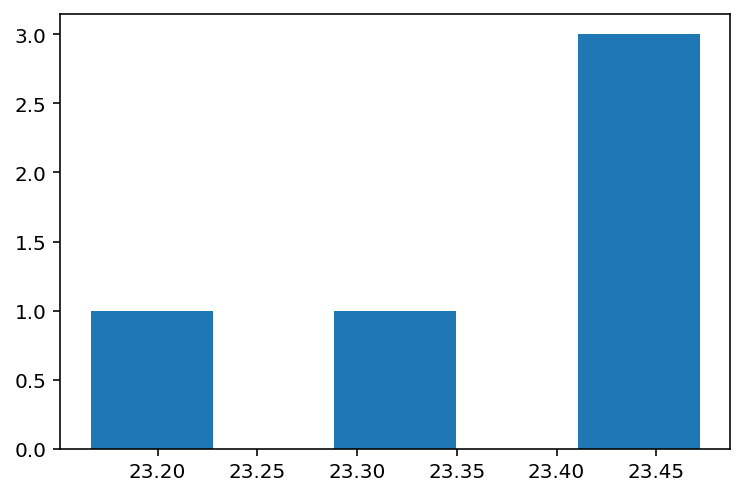

In [108]:
plt.hist(test_losses)
plt.show()

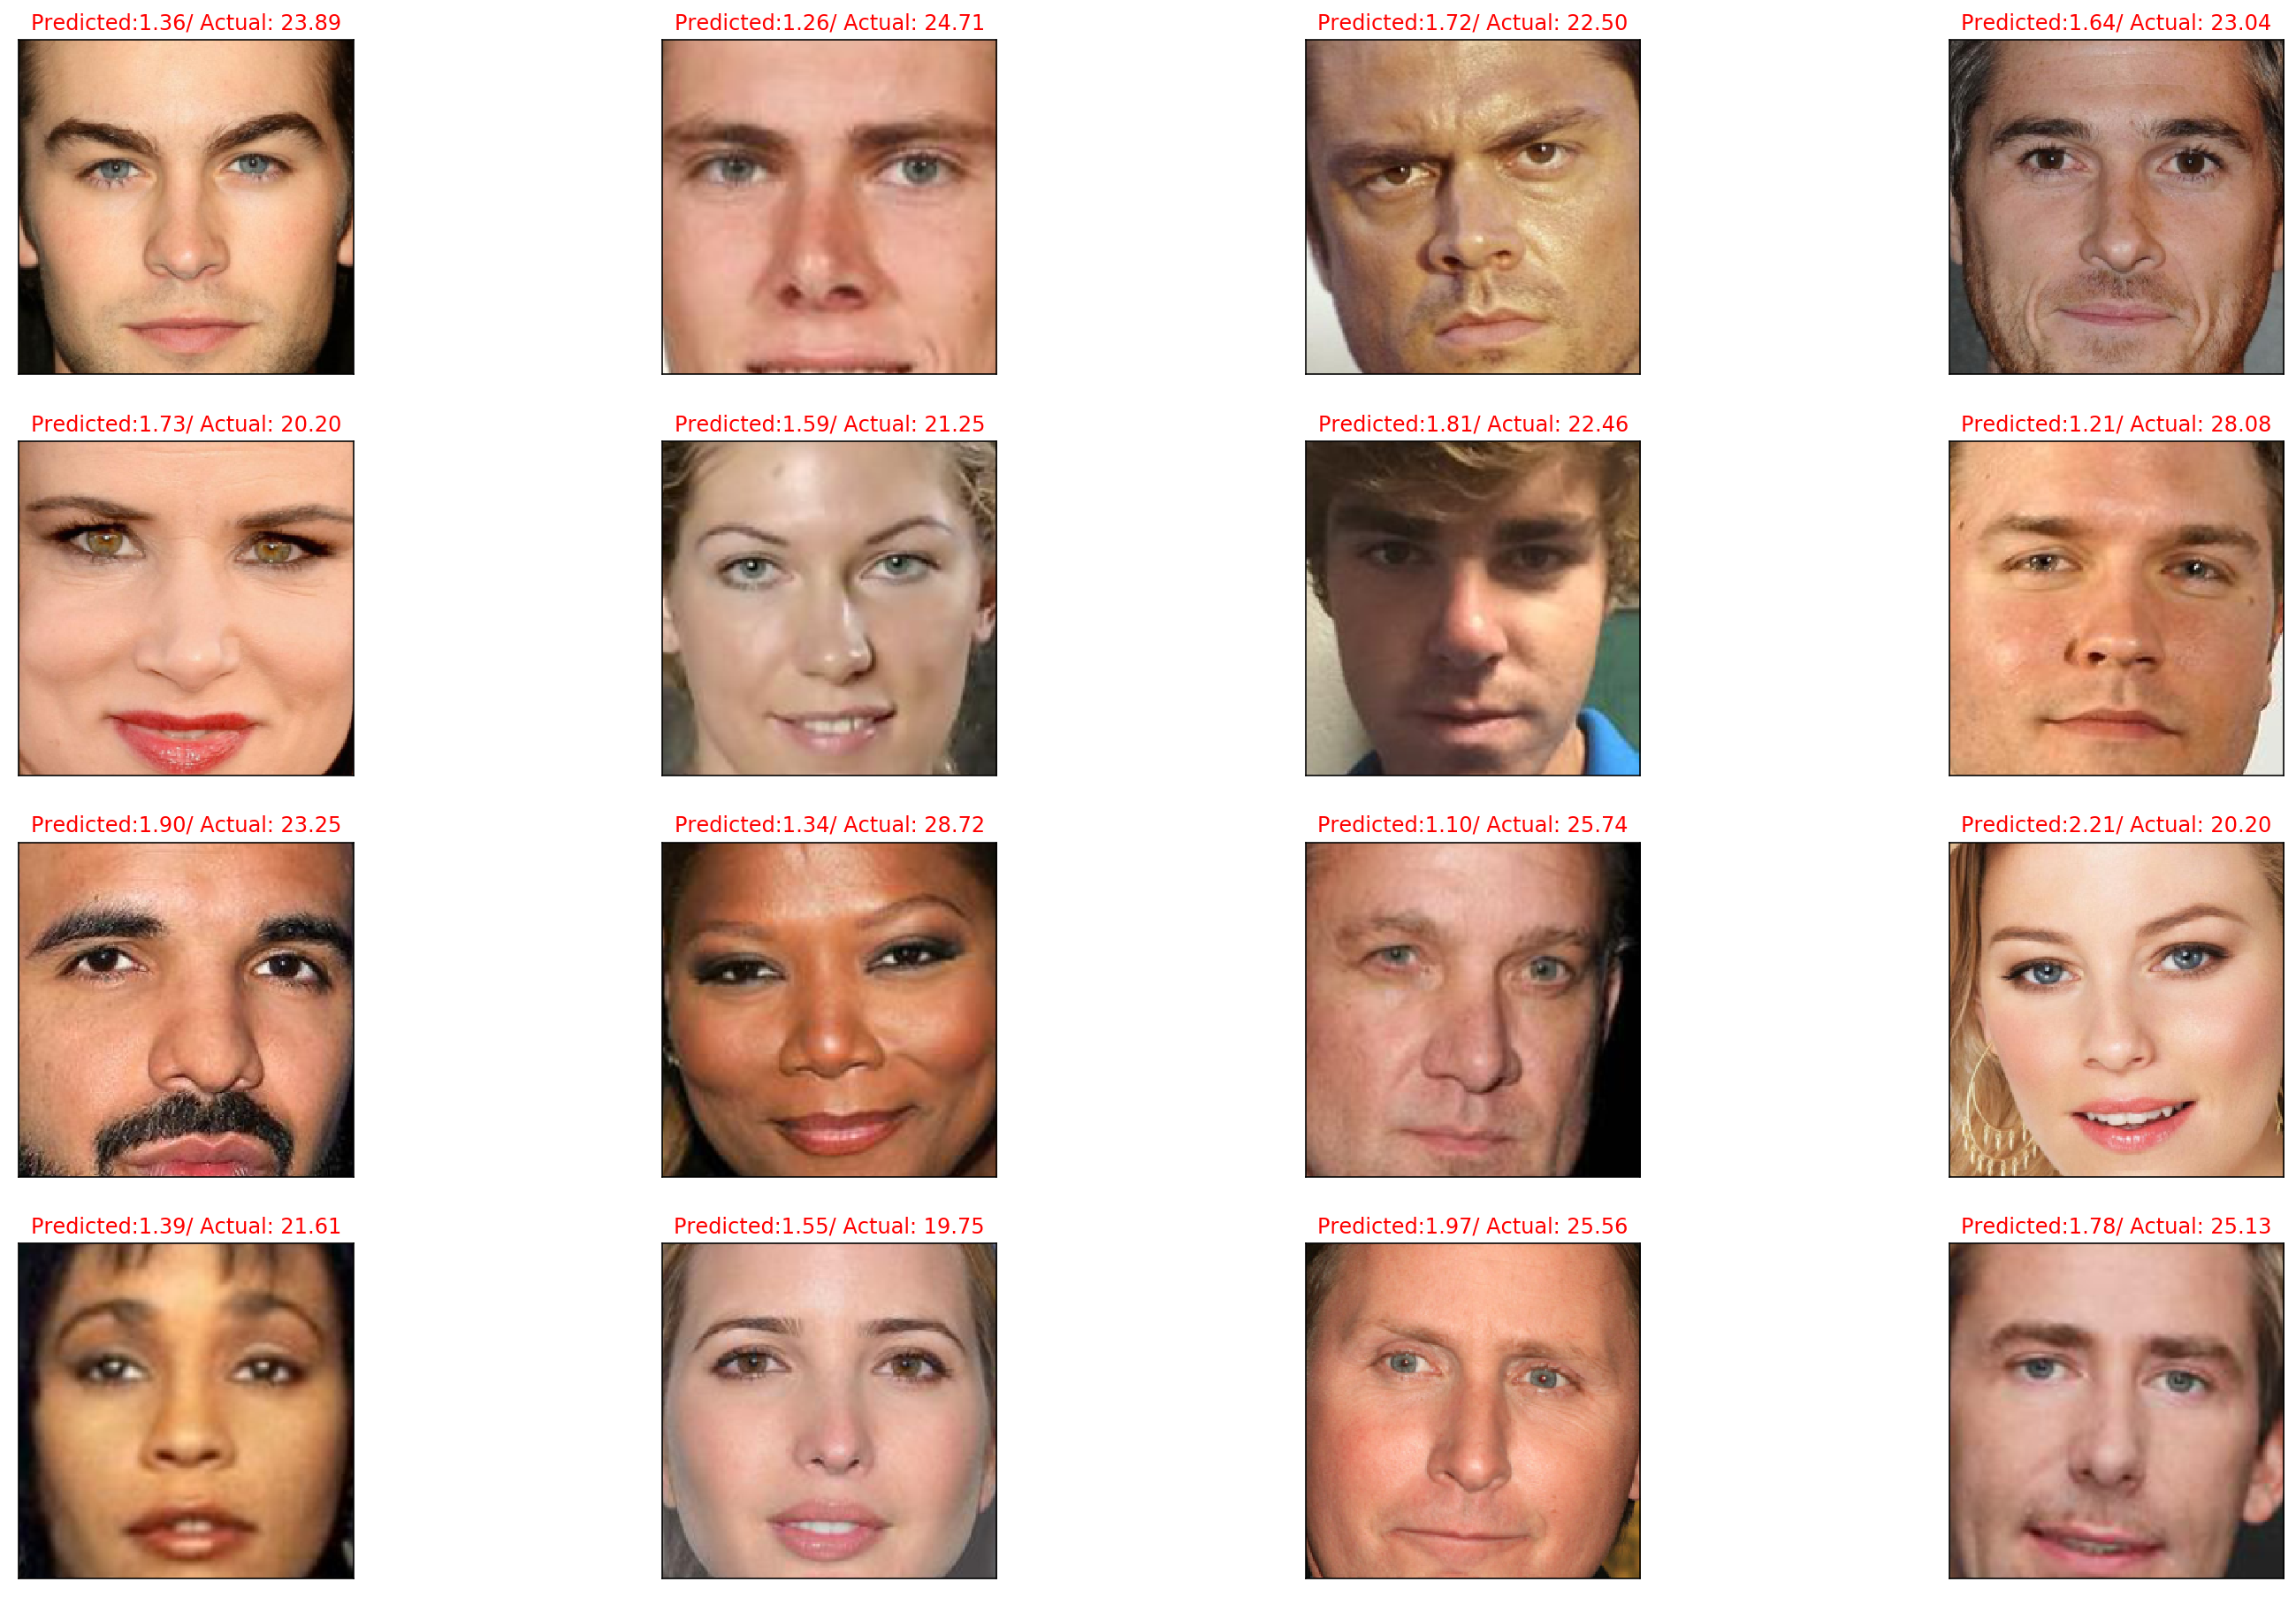

In [64]:
model.load_state_dict(torch.load('../models/trained/best_model.pt'));

# obtain one batch of test images
images, height, weight, bmi = next(iter(test_loader))

# get sample predictions
predictions = model(images)

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, cfg.batch_size))

for idx in np.arange(cfg.batch_size):
    ax = fig.add_subplot(4, cfg.batch_size/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx,:], (1,2,0)))
    ax.set_title(
        "Predicted:{:.2f}/ Actual: {:.2f}".format(predictions[idx,:].item(), bmi[idx,:].item()), 
                    color=("green" if predictions[idx,:].item() == bmi[idx,:].item() else "red"))

In [62]:
# Split data
split = DataSplit(total_dataset, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=cfg.batch_size)

#Setting criterion and loggin
criterion = nn.SmoothL1Loss()
if train_on_gpu:
    criterion.cuda()

train_losses, valid_losses = [], []
valid_loss_min = np.Inf

#training model
for epoch in range(epochs):
    learning_rate = cfg.base_learning_rate*(1+cfg.gamma*epoch)**(-cfg.power)
    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=cfg.weight_decay, momentum=0.9)
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, _, _, bmi in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, bmi = images.cuda(), bmi.cuda()

        # Reset optimizer
        optimizer.zero_grad()

        #Training model
        predictions = model(images)

        #Calculate loss
        loss = criterion(predictions, bmi)
        
        #Backpropagation
        loss.backward()

        #Update weight
        optimizer.step()
    
        #Calculate running loss
        train_loss += loss.item()*images.size(0)

    ######################    
    # validate the model #
    ######################

    else:
        model.eval()   
        #Turn off the gradient descent, save memory and computations
        for images, _, _, bmi in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, bmi = images.cuda(), bmi.cuda()
                
            #Run model
            predictions = model(images)
            loss = criterion(predictions,bmi)
            valid_loss += loss.item()*images.size(0)
    
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(
            "Epoch: {}/{}..".format(epoch+1, epochs),
            "Training loss: {:.3f}".format(train_loss),
            "Validating loss: {:.3f}".format(valid_loss)
        )
         
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), '../models/trained/best_model.pt') # for testing
            valid_loss_min = valid_loss

Epoch: 1/1.. Training loss: 21.943 Validating loss: 20.646
Validation loss decreased (inf --> 20.645766).  Saving model ...


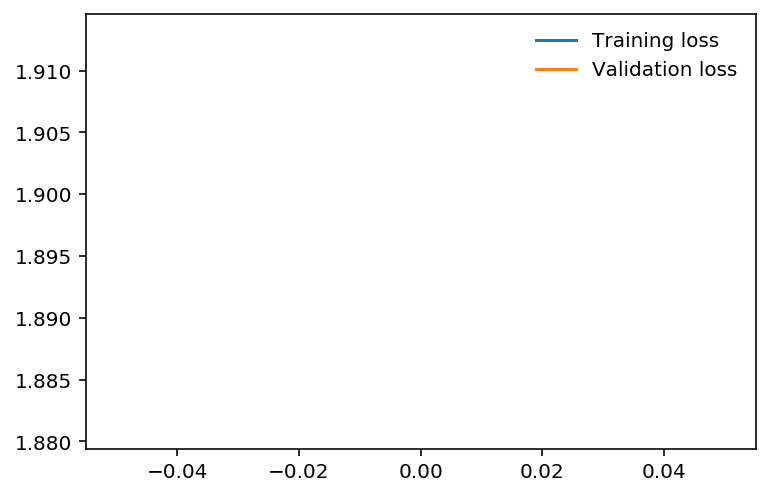

In [46]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend(frameon=False);

In [63]:
# Testing function
def testing(current_try):
    # model.load_state_dict(torch.load('../models/trained/best_model_'+str(current_try)+'.pt'));
    model.load_state_dict(torch.load('../models/trained/best_model.pt'));
    test_loss = 0.0
    model.eval()
    test_criterion = nn.L1Loss()
    for images, _, _, bmi in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, bmi = images.cuda(), bmi.cuda()
            test_criterion = test_criterion.cuda()
        
        #Run model
        predictions = model(images)
        loss = test_criterion(predictions,bmi)
        test_loss += loss.item()*images.size(0)

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss of {}-th try: {:.3f}\n'.format(current_try, test_loss))
    test_losses.append(test_loss)

testing(1)

Test Loss of 1-th try: 4.317

